# Домашнее задание. Классификация изображений



Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.




### Установка зависимостей

Ссылка на каггл: https://www.kaggle.com/elalehandrinho

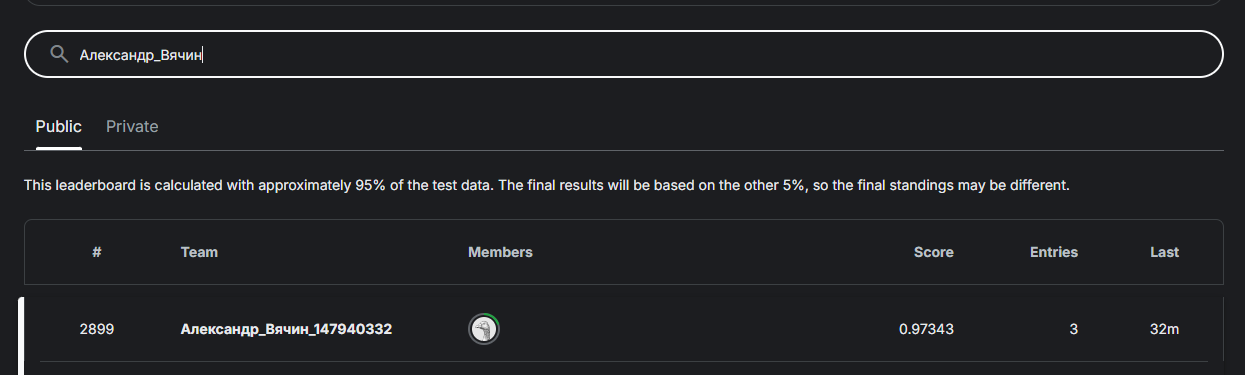

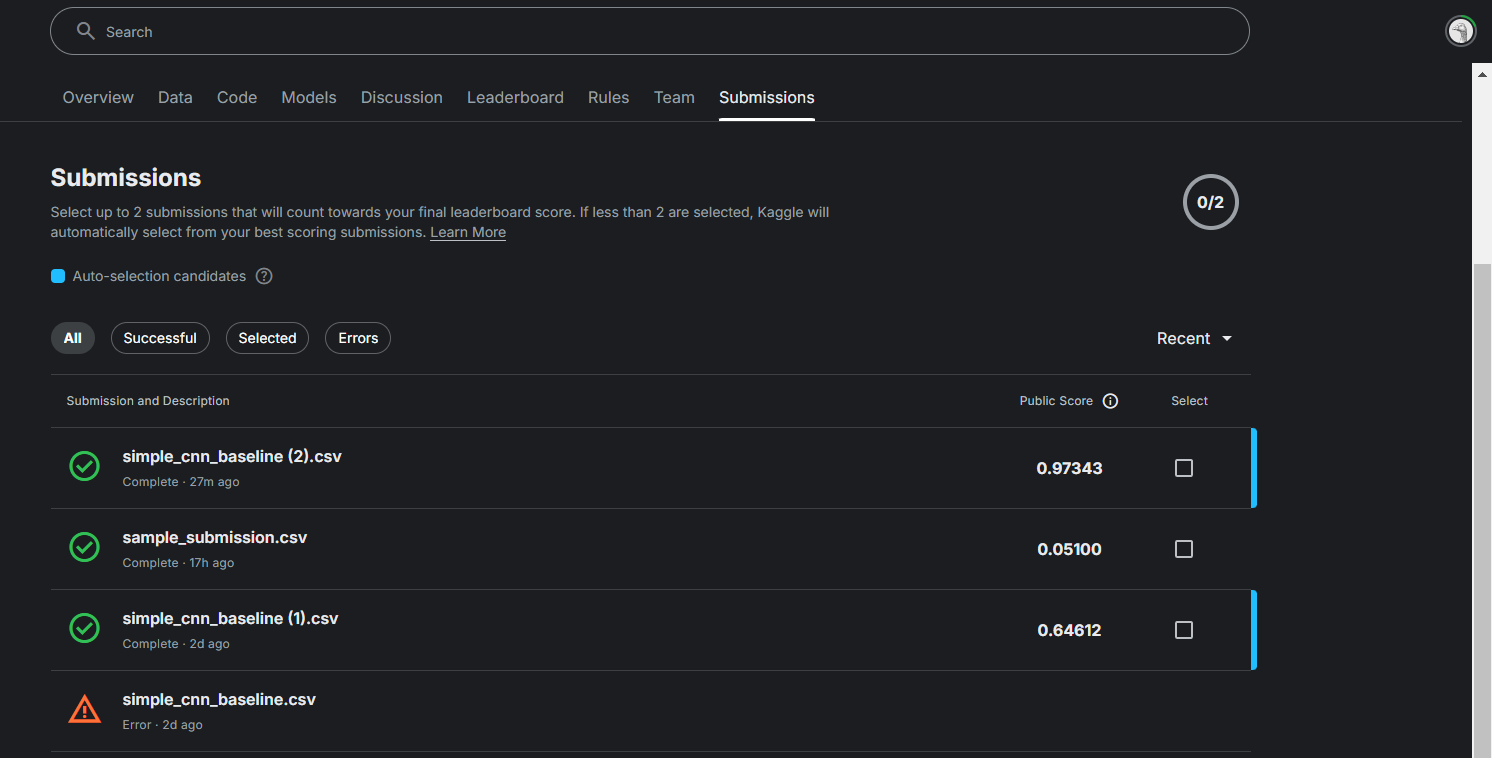

In [1]:
# we will verify that GPU is enabled for this notebook

# following should print: CUDA is available!  Training on GPU ...

#

# if it prints otherwise, then you need to enable GPU:

# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU



import torch

import numpy as np



train_on_gpu = torch.cuda.is_available()



if not train_on_gpu:

    print('CUDA is not available.  Training on CPU ...')

else:

    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:

import PIL

print(PIL.__version__)

11.0.0


In [3]:
! conda install -y gdown

/bin/bash: line 1: conda: command not found


In [4]:
!gdown --id 1gpmQSS62A8PRHR0ipjkEHmYuGKyxKa0L

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gpmQSS62A8PRHR0ipjkEHmYuGKyxKa0L
From (redirected): https://drive.google.com/uc?id=1gpmQSS62A8PRHR0ipjkEHmYuGKyxKa0L&confirm=t&uuid=9c8d64cd-7622-4175-a088-be9e2962a3ae
To: /content/journey-springfield.zip
100% 546M/546M [00:11<00:00, 46.8MB/s]


In [5]:
!unzip journey-springfield.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [6]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi

import torch

torch.cuda.is_available()

Thu Nov 21 13:16:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
import pickle

import numpy as np

from skimage import io



from tqdm import tqdm, tqdm_notebook

from PIL import Image

from pathlib import Path



from torchvision import transforms

from multiprocessing.pool import ThreadPool

from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn



from matplotlib import colors, pyplot as plt

%matplotlib inline



# в sklearn не все гладко, чтобы в colab удобно выводить картинки

# мы будем игнорировать warnings

import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [28]:
# разные режимы датасета

DATA_MODES = ['train', 'val', 'test', 'augm'] # добавлял augm для аугментации, но в итоге не использовад

# все изображения будут масштабированы к размеру 224x224 px

RESCALE_SIZE = 244 #изменено под densenet и resnet

# работаем на видеокарте

DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.



ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet





Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.

 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [10]:
class SimpsonsDataset(Dataset):

    """

    Датасет с картинками, который паралельно подгружает их из папок

    производит скалирование и превращение в торчевые тензоры

    """

    def __init__(self, files, mode):

        super().__init__()

        # список файлов для загрузки

        self.files = sorted(files)

        # режим работы

        self.mode = mode



        if self.mode not in DATA_MODES:

            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")

            raise NameError



        self.len_ = len(self.files)



        self.label_encoder = LabelEncoder()



        if self.mode != 'test':

            self.labels = [path.parent.name for path in self.files]

            self.label_encoder.fit(self.labels)



            with open('label_encoder.pkl', 'wb') as le_dump_file:

                  pickle.dump(self.label_encoder, le_dump_file)



    def __len__(self):

        return self.len_



    def load_sample(self, file):

        image = Image.open(file)

        image.load()

        return image



    def __getitem__(self, index):

        # для преобразования изображений в тензоры PyTorch и нормализации входа

        transform = transforms.Compose([

            transforms.ToTensor(),

            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ])

        # аугментация

        transform_augm = transforms.Compose([

            transforms.RandomRotation(degrees=30),

            transforms.ColorJitter(contrast=15,brightness=15),

            transforms.ToTensor(),

            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ])

        x = self.load_sample(self.files[index])

        x = self._prepare_sample(x)

        x = np.array(x / 255, dtype='float32')

        if self.mode == 'augm':

            x = transform_augm(x)

        else:

            x = transform(x)

        if self.mode == 'test': # 244x244

            return x

        else:

            label = self.labels[index]

            label_id = self.label_encoder.transform([label])

            y = label_id.item()

            return x, y



    def _prepare_sample(self, image):

        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))

        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    """Imshow для тензоров"""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)

    if title is not None:

        plt_ax.set_title(title)

    plt_ax.grid(False)

In [12]:
#определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('./train/')

TEST_DIR = Path('./testset')

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [16]:
# uncomment if you have problem with pillow

# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()

# Image.register_extension = register_extension

# def register_extensions(id, extensions):

#     for extension in extensions: register_extension(id, extension)

# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

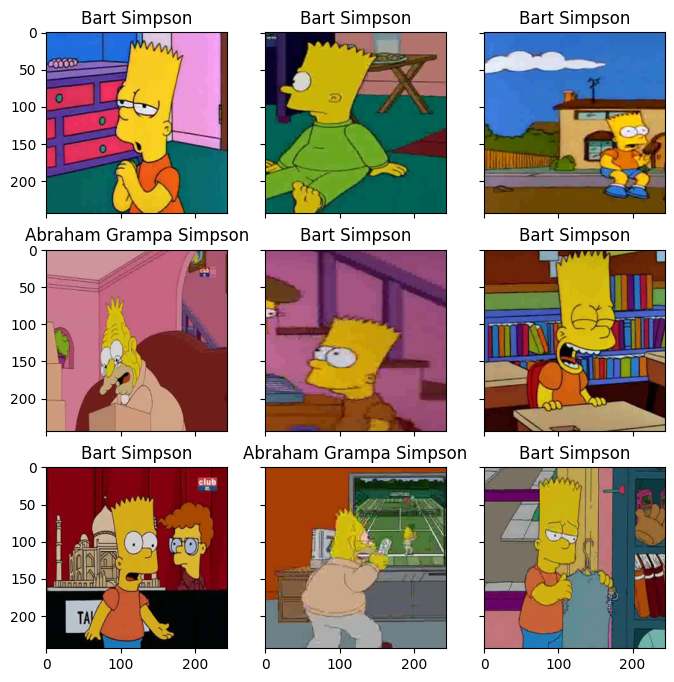

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):

    running_loss = 0.0

    running_corrects = 0

    processed_data = 0



    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        optimizer.zero_grad()



        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_data += inputs.size(0)



    train_loss = running_loss / processed_data

    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    processed_size = 0



    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)



        with torch.set_grad_enabled(False):

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)



        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [20]:
def train(train_files, val_files, model, epochs, batch_size):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"



    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = torch.optim.AdamW(model.parameters(), lr=0.003) #AdamW + amsgrad

        criterion = nn.CrossEntropyLoss()



        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)



            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))



            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\

                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))



    return history

In [21]:
def predict(model, test_loader):

    with torch.no_grad():

        logits = []



        for inputs in test_loader:

            inputs = inputs.to(DEVICE)

            model.eval()

            outputs = model(inputs).cpu()

            logits.append(outputs)



    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

Запустим обучение сети.

In [22]:
if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val')



train_dataset = SimpsonsDataset(train_files, mode='train')#+ SimpsonsDataset(train_files, mode='augm')

In [33]:
from torchvision import models

In [34]:
resnet18 = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# заморозка 3/4 части нейронки
c = 0
for param in resnet18.parameters():
    param.requires_grad = False
    c += 1
    if c == 47:
        break

resnet18.fc = nn.Linear(512, 42)

In [36]:
# закидываем на ГПУ
resnet18 = resnet18.to(DEVICE)

In [37]:
history = train(train_dataset, val_dataset, model=resnet18, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6505328569794029


epoch:  10%|█         | 1/10 [02:45<24:50, 165.66s/it]


Epoch 001 train_loss: 0.6505 val_loss 0.3640 train_acc 0.8420 val_acc 0.9064
loss 0.36387017542970085


epoch:  20%|██        | 2/10 [05:20<21:16, 159.56s/it]


Epoch 002 train_loss: 0.3639 val_loss 0.3953 train_acc 0.9022 val_acc 0.9014
loss 0.19365416577294553


epoch:  30%|███       | 3/10 [07:48<17:57, 153.91s/it]


Epoch 003 train_loss: 0.1937 val_loss 0.3618 train_acc 0.9483 val_acc 0.9110
loss 0.09806334702292706


epoch:  40%|████      | 4/10 [10:20<15:18, 153.16s/it]


Epoch 004 train_loss: 0.0981 val_loss 0.3572 train_acc 0.9735 val_acc 0.9209
loss 0.08064803391641868


epoch:  50%|█████     | 5/10 [12:52<12:44, 152.88s/it]


Epoch 005 train_loss: 0.0806 val_loss 0.3105 train_acc 0.9773 val_acc 0.9379
loss 0.05579242647179214


epoch:  60%|██████    | 6/10 [15:23<10:08, 152.14s/it]


Epoch 006 train_loss: 0.0558 val_loss 0.3560 train_acc 0.9841 val_acc 0.9335
loss 0.05512949862205433


epoch:  70%|███████   | 7/10 [17:54<07:35, 151.76s/it]


Epoch 007 train_loss: 0.0551 val_loss 0.3712 train_acc 0.9851 val_acc 0.9287
loss 0.02908841050858501


epoch:  80%|████████  | 8/10 [20:26<05:03, 151.84s/it]


Epoch 008 train_loss: 0.0291 val_loss 0.3488 train_acc 0.9916 val_acc 0.9362
loss 0.029879984190748405


epoch:  90%|█████████ | 9/10 [22:57<02:31, 151.51s/it]


Epoch 009 train_loss: 0.0299 val_loss 0.4110 train_acc 0.9920 val_acc 0.9241
loss 0.06424069491515702


epoch: 100%|██████████| 10/10 [25:35<00:00, 153.51s/it]


Epoch 010 train_loss: 0.0642 val_loss 0.3542 train_acc 0.9827 val_acc 0.9343


In [38]:
loss, acc, val_loss, val_acc = zip(*history)

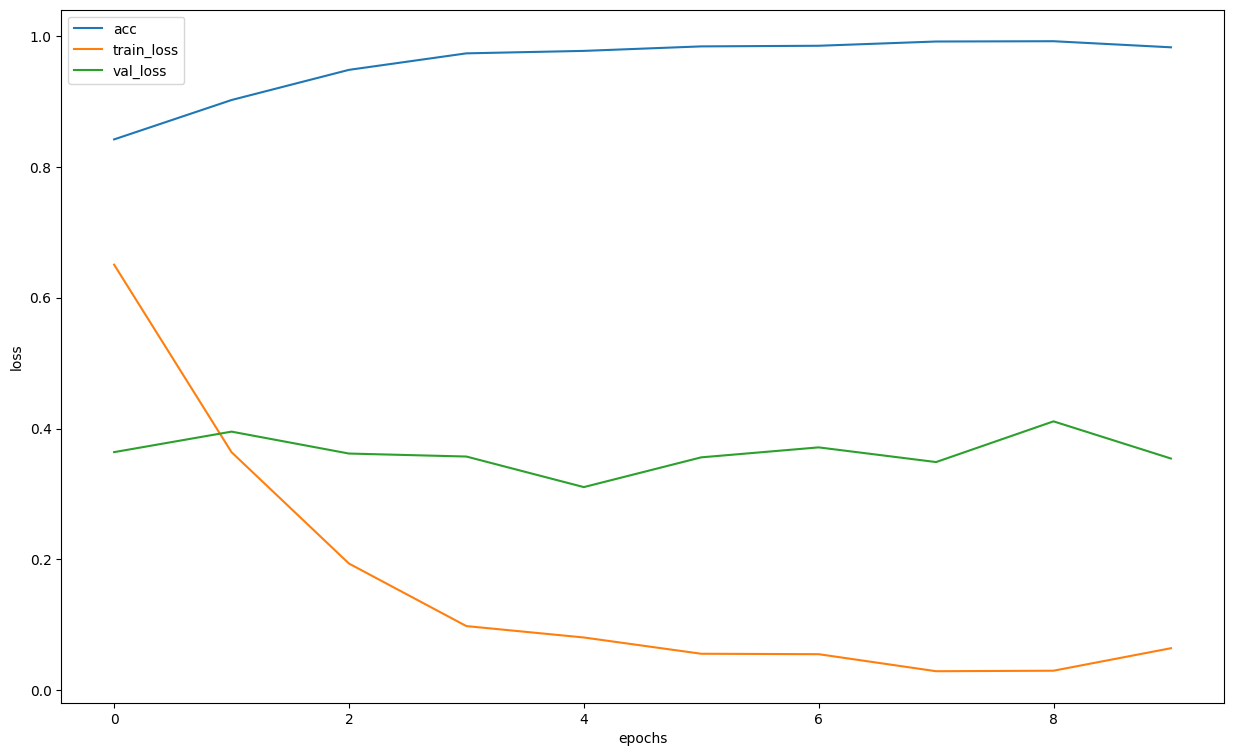

In [39]:
plt.figure(figsize=(15, 9))

plt.plot(acc, label="acc")

#plt.plot(val_acc, label="val_loss")

plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.

У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [40]:
def predict_one_sample(model, inputs, device=DEVICE):

    """Предсказание, для одной картинки"""

    with torch.no_grad():

        inputs = inputs.to(device)

        model.eval()

        logit = model(inputs).cpu()

        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs

In [41]:
random_characters = int(np.random.uniform(0,1000))

ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(resnet18, ex_img.unsqueeze(0))

In [42]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]



probs_ims = predict(resnet18, imgs)

In [43]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
y_pred = np.argmax(probs_ims,-1)



actual_labels = [val_dataset[id][1] for id in idxs]



preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [45]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')



print("F1-оценка:", f1)


F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

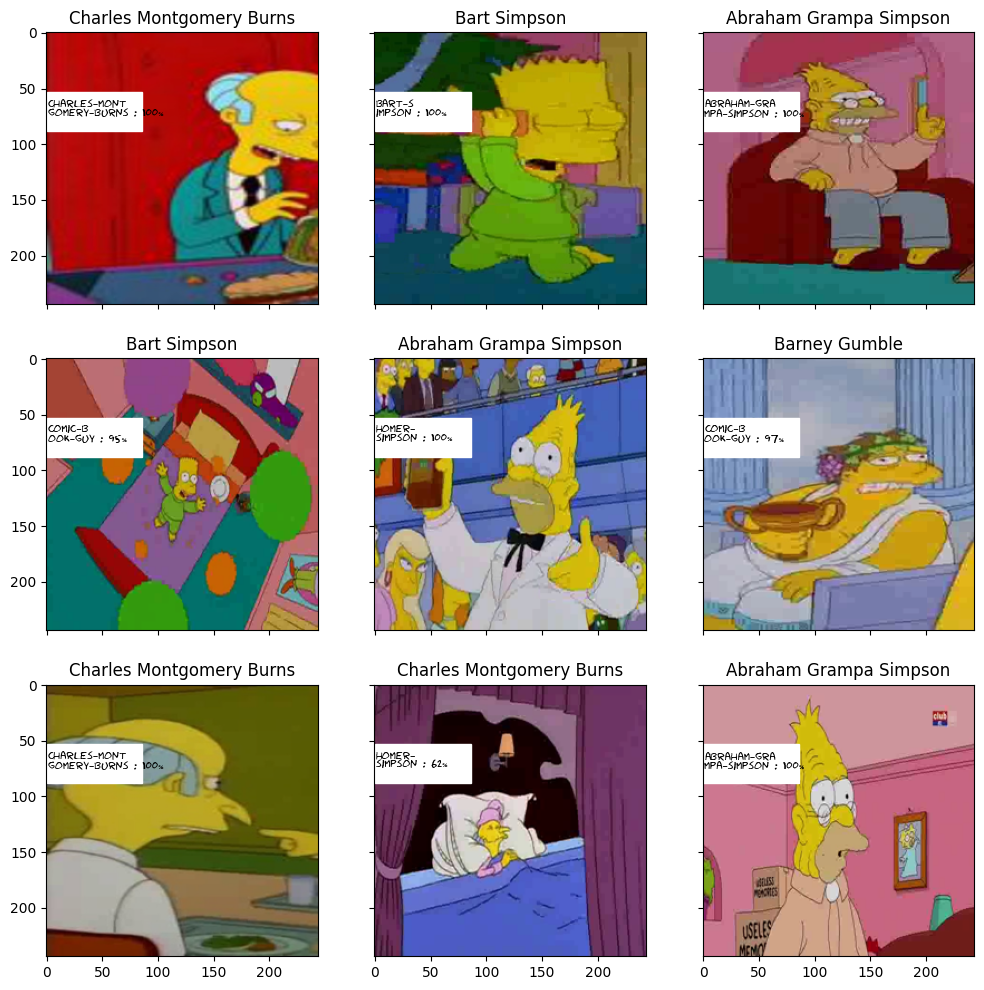

In [46]:
import matplotlib.patches as patches

from matplotlib.font_manager import FontProperties



fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))







    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)



    actual_text = "Actual : {}".format(img_label)



    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))

    font0 = FontProperties()

    font = font0.copy()

    font.set_family("fantasy")

    prob_pred = predict_one_sample(resnet18, im_val.unsqueeze(0))

    predicted_proba = np.max(prob_pred)*100

    y_pred = np.argmax(prob_pred)



    predicted_label = label_encoder.classes_[y_pred]

    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]

    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)



    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,

                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [47]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet18, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [48]:
preds

array(['nelson_muntz', 'bart_simpson', 'ned_flanders', 'chief_wiggum',
       'apu_nahasapeemapetilon', 'kent_brockman', 'edna_krabappel',
       'chief_wiggum', 'lisa_simpson', 'kent_brockman', 'lenny_leonard',
       'marge_simpson', 'kent_brockman', 'ned_flanders', 'moe_szyslak',
       'comic_book_guy', 'abraham_grampa_simpson', 'edna_krabappel',
       'kent_brockman', 'lisa_simpson', 'marge_simpson', 'nelson_muntz',
       'comic_book_guy', 'mayor_quimby', 'homer_simpson',
       'apu_nahasapeemapetilon', 'krusty_the_clown', 'krusty_the_clown',
       'ned_flanders', 'edna_krabappel', 'apu_nahasapeemapetilon',
       'chief_wiggum', 'apu_nahasapeemapetilon', 'ned_flanders',
       'marge_simpson', 'abraham_grampa_simpson', 'homer_simpson',
       'sideshow_bob', 'lisa_simpson', 'charles_montgomery_burns',
       'chief_wiggum', 'kent_brockman', 'abraham_grampa_simpson',
       'milhouse_van_houten', 'lenny_leonard', 'abraham_grampa_simpson',
       'nelson_muntz', 'comic_book_guy

In [49]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
journey-springfield.zip      sample_data	testset


In [50]:
import pandas as pd

#my_submit = pd.read_csv("/content/sample_submission.csv")

my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})

my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [51]:
preds

array(['nelson_muntz', 'bart_simpson', 'ned_flanders', 'chief_wiggum',
       'apu_nahasapeemapetilon', 'kent_brockman', 'edna_krabappel',
       'chief_wiggum', 'lisa_simpson', 'kent_brockman', 'lenny_leonard',
       'marge_simpson', 'kent_brockman', 'ned_flanders', 'moe_szyslak',
       'comic_book_guy', 'abraham_grampa_simpson', 'edna_krabappel',
       'kent_brockman', 'lisa_simpson', 'marge_simpson', 'nelson_muntz',
       'comic_book_guy', 'mayor_quimby', 'homer_simpson',
       'apu_nahasapeemapetilon', 'krusty_the_clown', 'krusty_the_clown',
       'ned_flanders', 'edna_krabappel', 'apu_nahasapeemapetilon',
       'chief_wiggum', 'apu_nahasapeemapetilon', 'ned_flanders',
       'marge_simpson', 'abraham_grampa_simpson', 'homer_simpson',
       'sideshow_bob', 'lisa_simpson', 'charles_montgomery_burns',
       'chief_wiggum', 'kent_brockman', 'abraham_grampa_simpson',
       'milhouse_van_houten', 'lenny_leonard', 'abraham_grampa_simpson',
       'nelson_muntz', 'comic_book_guy

In [52]:
for i in range(len(test_files)):

  my_submit.loc[i, 'Image_id'] = str(test_files[i])[str(test_files[i]).find('img'):]

my_submit.Expected = preds

In [53]:
my_submit.rename(columns = {'Image_id': 'Id'}, inplace=True)



In [54]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

In [55]:
my_submit


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,lisa_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


Вывод:
resnet18 с обучением последних 25% + adamW + lr=0.003
дали результат 0.9734 на каггле.